# Introduction to Moveless

This notebook serves as a **getting-started guide** for using our QCCD compiler, **Moveless**.

We will:

1. **Compile and gather execution times** for each circuit using the respective compiler.  
2. **Convert results into a portable format** containing timings and schedules.  
3. **Generate Stim circuit files** from those schedules.  
4. **Evaluate the logical error rate**, using independent decoding frameworks for:
   - Surface codes  
   - Color codes

## Step 0

We must setup the environment by **downloading** all the requirements, found in requirements.txt **(Must use Python 3.8)**

In [ ]:
!pip install -r requirements.txt

## Step 1

First, **load** all of the codes to run

In [2]:
import subprocess as sp
import os
import csv
import math



PROG = []

In [3]:
###COLOR CODES

def add_color_codes(PROG):
    arr = os.listdir("Circuits/CodeFamilies/ColorCodes/")
    for x in arr:
        circ = x
        n = int(circ.split("-")[0])
        max_ancillas = n - 1
        real_ancilla_of_circuit = int(circ.split("_code")[1].split("Ancilla")[0])

        #Enforce Interval Cutoffs for different Ancilla Values (optional)
        if (real_ancilla_of_circuit == 1 or real_ancilla_of_circuit == round(0.2 * max_ancillas) or real_ancilla_of_circuit == round(0.4 * max_ancillas) or real_ancilla_of_circuit == round(0.6 * max_ancillas) or real_ancilla_of_circuit == round(0.8 * max_ancillas) or real_ancilla_of_circuit == max_ancillas):
            PROG.append("Circuits/CodeFamilies/ColorCodes/" + x)

add_color_codes(PROG)

In [4]:
###SURFACE CODES

def add_surface_codes(PROG):
    arr = os.listdir("Circuits/CodeFamilies/SurfaceCodes/")
    for x in arr:
        circ = x
        n = int(circ.split("-")[0])
        max_ancillas = n - 1
        real_ancilla_of_circuit = int(circ.split("_code")[1].split("Ancilla")[0])

        #Enforce Interval Cutoffs for different Ancilla Values (optional)
        if (real_ancilla_of_circuit == 1 or real_ancilla_of_circuit == round(0.2 * max_ancillas) or real_ancilla_of_circuit == round(0.4 * max_ancillas) or real_ancilla_of_circuit == round(0.6 * max_ancillas) or real_ancilla_of_circuit == round(0.8 * max_ancillas) or real_ancilla_of_circuit == max_ancillas):
            if (n != 121):
                PROG.append("Circuits/CodeFamilies/SurfaceCodes/" + x)
#add_surface_codes(PROG)

In [5]:
###ARBITRARY STABILIZER CODES

def add_stabilizer_codes(PROG):
    arr = os.listdir("Circuits/Arbitrary_Stabilizer/")
    for x in arr:
        lines = [
        "5-1-3",
        "8-2-3",
        "10-1-4",
        "11-1-5",
        "12-2-4",
        "13-1-5",
        "14-2-5",
        "15-1-5",
        "16-2-6",
        "17-1-7",
        "19-1-7",
        "20-2-6",
        "21-1-7",
        "23-2-7",
        "25-1-9"]
        #arr = x.split("Circuits/Circuits/")
        circ = x
        n = int(circ.split("-")[0])
        k = int(circ.split("-")[1])
        d = int(circ.split("-")[2].split("_code")[0])
        max_ancillas = n - k
        real_ancilla_of_circuit = int(circ.split("_code")[1] .split("Ancilla")[0])
        if (real_ancilla_of_circuit == 1 or real_ancilla_of_circuit == round(0.2 * max_ancillas) or real_ancilla_of_circuit == round(0.4 * max_ancillas) or real_ancilla_of_circuit == round(0.6 * max_ancillas) or real_ancilla_of_circuit == round(0.8 * max_ancillas) or real_ancilla_of_circuit == max_ancillas):
            if (f"{n}-{k}-{d}" in lines):
                PROG.append("Circuits/Arbitrary_Stabilizer/" + x)

#add_stabilizer_codes(PROG)


In [6]:
###MACHINE/EXPERIMENTAL CONSTANTS SETUP
def run_compilers():
    filename = "Moveless_Example"


    log_file_string = f"{filename}.log" 
    csv_string = f"{filename}.csv" 
    output_file = open(log_file_string,'w')


    COMPILERS = ["Moveless", "Baseline", "MAO"] #Options are Moveless, Baseline, and MAO. 
    LER_MODE = True #switch on if the experiment will continue to generate exact timings files, stim files, and ultimately logical error rates. Turn off if you just want execution times in a csv.

    reorder = "Naive"

    row = ["Program Name","Ions Per Trap","Machine","Compiler Choice","Number of Ancilla", "Fidelity"]
    with open(csv_string, 'w', newline='') as outfile:
        writer = csv.writer(outfile)
        writer.writerow(row)


    #Can optionally declare a preset machine (or list of machines here) instead of a machine with variable traps according to code

    #MACHINE = ["L15", "C20"] #machine string choices defined in run.py and mapped to machine objects in test_machines.py
    for p in PROG:
        split_arr = p.split("-")
        remain = split_arr[0]
        k = int(split_arr[1])
        #num = remain.split("Cycles/")[1]
        num = remain.split("Codes/")[1]
        #num = remain.split("Circuits/")[1]
        #num = remain.split("DRCycles/")[1]
        n = int(num)
        C = n - k
        IONS = ["5"]
        
        CONSTANT = 1
        number_traps = math.ceil(C/CONSTANT)
        mach_string = "L" + str(number_traps)
        #print("NUMBER OF TRAPS", number_traps)
        print("RUNNING", p)

        MACHINE = [mach_string]
        LER_MODE = "True" #must be string form of boolean, capitalize first letter (sp can only interpret strings)
        for i in IONS:
            optimal = C
            for m in MACHINE:
                    for compiler in COMPILERS:
                        code = sp.call(["python", "run.py", p, m, i, compiler, 
                                    reorder, "1", "0", "0", "FM", "GateSwap", 
                                    csv_string, "80", LER_MODE], stdout=output_file) 
                        if (code != 0): #exit code success
                            print("There was an ERROR running", p, "Debug outside a notebook (can use run_batch.py).")
                            exit()




    print("Done Generating Execution Time Logs and CSV!")

###COMMENT THIS LINE OUT IF RERUNNING. DATA FILES ARE OVERWRITTEN UPON EACH RUN.
#~1 HR to run all benchmarks
#run_compilers()


## Step 2

Once the compilers have finished executing schedules and outputting gate times, it’s time to **benchmark the new circuits**—with all atomic operations accounted for—under realistic, hardware-aware noise models.

Process:

1. **Load compiled schedules** (from pickled files).  
2. **Parse into time slices**:  
   - Arrays represent each time step.  
   - Save both the gates and the timing for each step.  
3. **Generate Stim circuits** by writing directly to file:  
   - Each file executes the circuit **and its inverse** paired together.

In [ ]:
import pickle as pkl
import copy
import os
#This file was made originally in April '24 when baseline = greedy, and was coincidentally named baselineTimingsParser. The word baseline, greedy, and cyclone can all be used interchangeably.

def parseTimings(folder_name):
    astrings = ["0.2m", "0.4m", "0.6m", "0.8m", "1m", "maxm"]
    for ancilla_string in astrings:
        arr = os.listdir(folder_name + ancilla_string + "/") 
        print("arr", arr)
        for a in arr:
            if (a == '.gitkeep'):
                continue
            name = folder_name + ancilla_string + "/" + a
            with open(name, 'rb') as file:
                dictionary = pkl.load(file)
                cx_arr = [[]]
                timings = []
                curr_list = []
                layer = 0 #assumes the first thing we do is a gate
                oldlayer = 0
                operations = []
                timings_set = []
                print("new a is", a)
                if (a.split("_")[1] == "CxsBaseline.pkl" or a.split("_")[1] == "TimingsBaseline.pkl"): #pass on timings baseline files already made if using this script to make additional baseline timings files (RERUNNING THIS SCRIPT WITHOUT DELETING THEM)
                    print("SKIPPED (this file is already present in the folder)", a)
                    continue
                for x in dictionary:
                    if (len(x[4]['ions']) == 2):
                        operations.append(x)
                        if (x[1] == 1):#is a gate
                            #assert(x[2] + 100 == x[3]) ONLY HAVE THIS ASSERTION GO OFF IF ION CHAIN LENGTH IS LOW ENOUGH
                            if (x[3] not in timings_set):
                                timings_set.append(x[3])
                            layer = x[2]
                            if (layer != oldlayer):
                                cx_arr.append([(x[4]['ions'][0], x[4]['ions'][1])])
                                oldlayer = layer
                            else:
                                cx_arr[-1].append((x[4]['ions'][0], x[4]['ions'][1]))
                                oldlayer = layer
                base = 0
                print("timings set", timings_set)
                
                for x in timings_set:
                    new_time = x - base
                    timings.append(new_time)
                    base = x
                    dump_name_cx = folder_name + ancilla_string + "/" + a.split("_")[0] + "_CxsBaseline.pkl"
                    dump_name_timings = folder_name + ancilla_string + "/" + a.split("_")[0] + "_TimingsBaseline.pkl"
                print(cx_arr)
                print("timings", timings)
                print(len(cx_arr))
                print(len(timings))
                print("Sum for ", ancilla_string, ":")
                print(sum(timings))
                with open(dump_name_cx, "wb") as f1:
                    pkl.dump(cx_arr, f1)
                with open(dump_name_timings, "wb") as f2:
                    pkl.dump(timings, f2)

folder_names = ["Demo_Baseline_Timings/", "Demo_Moveless_Timings/"]
for name in folder_names:
    parseTimings(name)
print("Successfully generated time slice objects!")
                    

In [ ]:
import circuit_generator
import createStimCircs

#Can decide pphys values to generate the circuit. Default = [1e-4, 2e-4, 3e-4, 4e-4, 5e-4, 6e-4, 7e-4, 8e-4, 9e-4, 1e-3]
#Full method with more customizable parameters in createStimCircs
#Runtime < 1 minute
createStimCircs.run_create_stim_circs(pphys_range=[1e-4, 2e-4, 3e-4, 4e-4, 5e-4, 6e-4, 7e-4, 8e-4, 9e-4, 1e-3])
           

## Step 3

Finally, it’s time to **test the logical error rate** of the circuits and generate the corresponding plots to visualize the results.

In [ ]:
import stim
import sinter
from typing import List

def compute_ler_SC(file_name, compiler_mode, inputCircuit=None, ancilla_str="1m"):
    if (compiler_mode == "Moveless"):
        circuit = stim.Circuit.from_file("stim_files_Moveless/surface_codes/" + ancilla_str + "/" + file_name)
    elif (compiler_mode == "Baseline"):
        circuit = stim.Circuit.from_file("stim_files_Baseline/surface_codes/" + ancilla_str + "/" + file_name)
    elif (compiler_mode == "Test"):
        circuit = inputCircuit
    else:
        print("invalid compiler mode")
        assert(0)
    #print("FILE NAME", file_name)
    #print("Circuit", circuit)
    tasks = [
    sinter.Task(circuit=circuit)]
    #print("got to this point here after reading circuit")
    num_shots = 10_000_000
    collected_stats: List[sinter.TaskStats] = sinter.collect(
        num_workers=6,
        tasks=tasks,
        decoders=['pymatching'],
        max_shots=num_shots,
        max_errors=num_shots/100,
    )
    errors = collected_stats[0].errors
    #num_logical_errors = count_logical_errors(circuit, num_shots)
    #print("there were", num_logical_errors, "wrong predictions (logical errors) out of", num_shots, "shots")
    return errors/num_shots



def make_ler_plot_SC(compiler_mode, name, p_range=[0,1], ancilla_str="1m"):
    
    
    if (compiler_mode == "Moveless"):
        arr = os.listdir("stim_files_Moveless/surface_codes/" + ancilla_str + "/")
    elif (compiler_mode == "Baseline"):
        arr = os.listdir("stim_files_Baseline/surface_codes/"+ ancilla_str + "/")
    else:
        print("Unknown circuit generation mode")
        assert(0)
    #print("arr", arr)
    errors= []
    x_axis = []
    arr = sorted(arr)
    for x in arr:
        if (x.split("p")[0] == name): #I think it wont include full path so this should be good
            right = x.split("p=")[1]
            remainder = right.split("d=")[0]
            p = float(remainder)
            if (p_range[0] <= p and p <= p_range[1]):
                x_axis.append(p)
                print("Circuit is", x)
                ler = compute_ler_SC(x, compiler_mode=compiler_mode, ancilla_str=ancilla_str)
                print("Finished a computation for", p)
                print("Got ler", ler)
                errors.append(ler)
    print("x axis", x_axis)        
    return errors, x_axis



#Find Moveless LERS

#p range can be any subset of what circuits were generated in the creating stim circuit step.
#NOTE: Ensure sufficient shots are taken > 10*LER. 
#Naming convention is "n-k-d" for a given code SC/CC 
moveless_SC, x = make_ler_plot_SC("Moveless", "49-1-7", [1e-4, 1e-3], "1m")  #1M is chosen for best Moveless performance on linear architectures.
baseline_SC, x_baseline = make_ler_plot_SC("Baseline", "49-1-7", [1e-4, 1e-3], "maxm") #Baseline full ancillary count







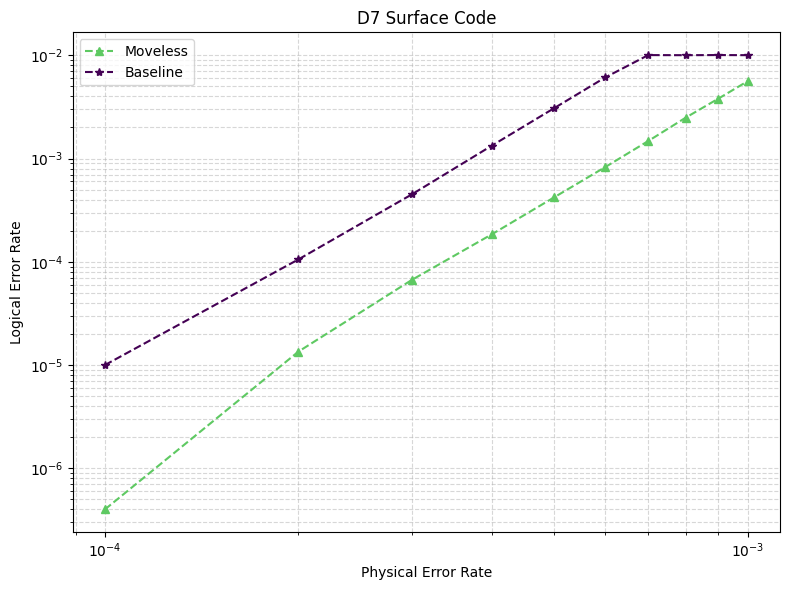

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm

def plot_LERS(x, moveless, baseline):
    # Get colors from viridis colormap
    colors = plt.get_cmap('viridis')(np.linspace(0, 1, 5))
    color_baseline = colors[0]
    color_moveless = colors[3]

    plt.figure(figsize=(8, 6))
    plt.plot(x, moveless, label='Moveless', marker='^', linestyle='--', linewidth=1.5, color=color_moveless)
    plt.plot(x, baseline, label='Baseline', marker='*', linestyle='--', linewidth=1.5, color=color_baseline)

    plt.xlabel('Physical Error Rate')
    plt.ylabel('Logical Error Rate')
    plt.grid(True, which='both', ls='--', alpha=0.5)
    plt.xscale('log')
    plt.yscale('log')
    plt.title("D7 Surface Code")
    plt.legend()
    plt.tight_layout()
    plt.show()


#assert(x == x_baseline)
plot_LERS(x, moveless_SC, baseline_SC)

## Conclusion

This concludes the **Moveless** tutorial.

For **color code decoding**, see the supplemental `color_codes` notebook.  
⚠️ *Note:* This requires a **custom environment setup** due to version conflicts between compiler partitioning libraries  and decoding libraries  

These dependencies require **different Python versions**, so they cannot be installed together in the same environment.

## How to Cite

If you use **Moveless** in your research, please cite:

> *Moveless: Minimizing Overhead on QCCDs via Versatile Execution and Low Excess Shuttling*  
> Sahil Khan, Suhas Vittal, Kenneth Brown, Jonathan Baker.  
> arXiv:2508.03914 [quant-ph], 2025.  
> [https://arxiv.org/abs/2508.03914](https://arxiv.org/abs/2508.03914)

BibTeX:
```bibtex
@misc{khan2025movelessminimizingoverheadqccds,
  title     = {Moveless: Minimizing Overhead on QCCDs via Versatile Execution and Low Excess Shuttling},
  author    = {Sahil Khan and Suhas Vittal and Kenneth Brown and Jonathan Baker},
  year      = {2025},
  eprint    = {2508.03914},
  archivePrefix = {arXiv},
  primaryClass  = {quant-ph},
  url       = {https://arxiv.org/abs/2508.03914}
}
